In [1]:
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from utils.wine_review_utils import vintage

# focus on Pinot Noirs from US
country = 'US'
province = 'California'
variety = 'Pinot Noir'
cols = ['description', 'points', 'region_1', 'winery', 'title']

# Download the dataset
path = kagglehub.dataset_download("christopheiv/winemagdata130k")
fname = 'winemag-data-130k-v2.csv'
reviews = pd.read_csv(os.path.join(path, fname), index_col=0).query(f'country == "{country}" and variety == "{variety}" and province == "{province}"')[cols]
reviews['year'] = reviews.title.apply(vintage)
reviews.dropna(subset=['year'], axis=0, inplace=True)
reviews.drop('title', axis=1, inplace=True)
reviews.year = reviews.year.astype(int)
reviews.info()
reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6888 non-null   object
 1   points       6888 non-null   int64 
 2   region_1     6886 non-null   object
 3   winery       6888 non-null   object
 4   year         6888 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 322.9+ KB


description  points  \
25   Oak and earth intermingle around robust aromas...      87   
145  Cooked cranberry is spiced with anise, pepperc...      91   
152  From a promising new project, the nose of this...      91   
169  This wine is put together from multiple vineya...      91   
181  Crisp, coastal acidity dominates this wine, ma...      88   

                  region_1               winery  year  
25            Sonoma Coast  Castello di Amorosa  2011  
145  Santa Lucia Highlands           Testarossa  2013  
152          Carmel Valley      Albatross Ridge  2012  
169   Russian River Valley     Dutton-Goldfield  2014  
181            Arroyo Seco   McIntyre Vineyards  2006

**Timing Helper**

In [2]:
import time
from collections import namedtuple
from IPython.display import display, Markdown

PERF = namedtuple('PERF', ['algo', 'duration'])

timings = []

def timeit(algo, purpose, func, count, items='documents'):
  start = time.perf_counter()
  result = func()
  elapsed = time.perf_counter()-start
  timings.append(PERF(algo, elapsed))
  display(Markdown(f'It took ${elapsed/60:.1f}$ minutes to {purpose} for ${count:,d}$ {items}.'))
  return result

_time = lambda algo, purpose, func, count=reviews.shape[0], items='reviews': timeit(algo, purpose, func, count, items)

**Description Length Feature**

In [3]:
review_length = _time('len', 'calculate description length', lambda: reviews.description.str.len())
review_length.name = 'description_len'
review_length.info()
review_length.sample(5, random_state=42)

It took $0.0$ minutes to calculate description length for $6,888$ reviews.

<class 'pandas.core.series.Series'>
Index: 6888 entries, 25 to 129920
Series name: description_len
Non-Null Count  Dtype
--------------  -----
6888 non-null   int64
dtypes: int64(1)
memory usage: 107.6 KB


22188     330
117324    263
30433     158
52906     283
105596    263
Name: description_len, dtype: int64

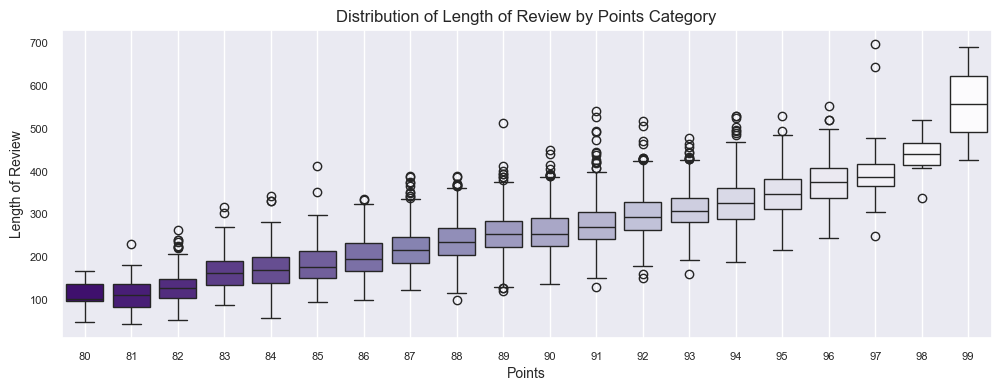

In [4]:
plt.figure(figsize=(12,4))
sns.boxplot(x = reviews.points, y = review_length, palette = 'Purples_r', hue=reviews.points, native_scale=False, legend=None)
plt.title("Distribution of Length of Review by Points Category", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Length of Review",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

**Bag of Words Features**

In [5]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

swords = stopwords.words('english') + ['year', 'years', 'wine', 'wines', 'country', 'variety']

vectorizer = CountVectorizer(stop_words=swords, min_df=.015, max_df=.95, token_pattern=r'\b[^\d\W]+\b')
bow = _time('BOW', 'calculate bag-of-words features', lambda: pd.DataFrame(vectorizer.fit_transform(reviews.description).toarray(), index=reviews.index, columns=vectorizer.get_feature_names_out()))
bow.info()
bow.sample(5, random_state=42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


It took $0.0$ minutes to calculate bag-of-words features for $6,888$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Columns: 313 entries, accented to young
dtypes: int64(313)
memory usage: 16.5 MB


accented  acidic  acidity  acids  age  alcohol  allspice  almost  \
22188          0       0        0      0    0        0         0       0   
117324         0       0        1      0    1        0         0       0   
30433          0       0        0      0    0        0         0       0   
52906          0       0        0      0    0        0         0       0   
105596         0       0        0      0    0        0         0       0   

        along  also  ...  weight  well  wet  white  wild  winemaker  winery  \
22188       0     0  ...       0     0    0      0     0          0       1   
117324      0     0  ...       0     0    0      0     0          0       0   
30433       0     0  ...       0     0    0      0     0          0       0   
52906       0     0  ...       0     0    0      0     0          0       0   
105596      0     0  ...       0     0    0      0     0          0       0   

        wrapped  yet  young  
22188         0    0      0  
117324        0    0      0  
30433         0    0      0  
52906         0    0      0  
105596        0    0      0  

[5 rows x 313 columns]

**TF-IDF Features**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=swords, min_df=.015, max_df=.95, token_pattern=r'\b[^\d\W]+\b')
tfidf = _time('TF-IDF', 'calculate TF-IDF features', lambda: pd.DataFrame(vectorizer.fit_transform(reviews.description).toarray(), index=reviews.index, columns=vectorizer.get_feature_names_out()))
tfidf.info()
tfidf.sample(5, random_state=42)

It took $0.0$ minutes to calculate TF-IDF features for $6,888$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Columns: 313 entries, accented to young
dtypes: float64(313)
memory usage: 16.5 MB


accented  acidic   acidity  acids      age  alcohol  allspice  almost  \
22188        0.0     0.0  0.000000    0.0  0.00000      0.0       0.0     0.0   
117324       0.0     0.0  0.133535    0.0  0.25485      0.0       0.0     0.0   
30433        0.0     0.0  0.000000    0.0  0.00000      0.0       0.0     0.0   
52906        0.0     0.0  0.000000    0.0  0.00000      0.0       0.0     0.0   
105596       0.0     0.0  0.000000    0.0  0.00000      0.0       0.0     0.0   

        along  also  ...  weight  well  wet  white  wild  winemaker    winery  \
22188     0.0   0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0  0.306764   
117324    0.0   0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0  0.000000   
30433     0.0   0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0  0.000000   
52906     0.0   0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0  0.000000   
105596    0.0   0.0  ...     0.0   0.0  0.0    0.0   0.0        0.0  0.000000   

        wrapped  yet  young  
22188       0.0  0.0    0.0  
117324      0.0  0.0    0.0  
30433       0.0  0.0    0.0  
52906       0.0  0.0    0.0  
105596      0.0  0.0    0.0  

[5 rows x 313 columns]

**Custom Tokenizer BOW Features**

In [7]:
import spacy

nlp = spacy.load("en_core_web_lg")

def preprocess(doc):
  # drop punctuation, proper nouns, numbers and stop words
  keep = lambda token: (token[1] not in ['PUNCT','PROPN', 'NUM']) and (token[2] == 0)
  # run the preprocessing pipeline
  return (' '.join(map(lambda token: token[0], filter(keep, [(w.lemma_, w.pos_, w.is_stop) for w in nlp(doc)])))).strip()

vectorizer = CountVectorizer(token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess)
bow_spacy = _time('spaCy BOW', 'calculate spaCy bag-of-words features', lambda: pd.DataFrame(vectorizer.fit_transform(reviews.description).toarray(), index=reviews.index, columns=vectorizer.get_feature_names_out()))
bow_spacy.drop('year', axis=1, inplace=True)
bow_spacy.info()
bow_spacy.sample(5, random_state=42)

It took $1.2$ minutes to calculate spaCy bag-of-words features for $6,888$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Columns: 5354 entries, Drew to zone
dtypes: int64(5354)
memory usage: 281.4 MB


Drew  Dry  Now  Sangiovese  Set  Woodsy  abandon  abbreviate  ability  \
22188      0    0    0           0    0       0        0           0        0   
117324     0    0    0           0    0       0        0           0        0   
30433      0    0    0           0    0       0        0           0        0   
52906      0    0    0           0    0       0        0           0        0   
105596     0    0    0           0    0       0        0           0        0   

        able  ...  zero  zest  zestiness  zesty  zing  zinge  zingy  zip  \
22188      0  ...     0     0          0      0     0      0      0    0   
117324     0  ...     0     0          0      0     0      0      0    0   
30433      0  ...     0     0          0      0     0      0      0    0   
52906      0  ...     0     0          0      0     0      0      0    0   
105596     0  ...     0     0          0      0     0      0      0    0   

        zippy  zone  
22188       0     0  
117324      0     0  
30433       0     0  
52906       0     0  
105596      0     0  

[5 rows x 5354 columns]

**Custom TF-IDF Tokenizer Features**

In [8]:
vectorizer = TfidfVectorizer(token_pattern=r'\b[^\d\W]+\b', preprocessor=preprocess)
tfidf_spacy = _time('spaCy TF-IDF', 'calculate spaCy TF-IDF features', lambda: pd.DataFrame(vectorizer.fit_transform(reviews.description).toarray(), index=reviews.index, columns=vectorizer.get_feature_names_out()))
tfidf_spacy.drop('year', axis=1, inplace=True)
tfidf_spacy.info()
tfidf_spacy.sample(5, random_state=42)

It took $1.1$ minutes to calculate spaCy TF-IDF features for $6,888$ reviews.

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Columns: 5354 entries, Drew to zone
dtypes: float64(5354)
memory usage: 281.4 MB


Drew  Dry  Now  Sangiovese  Set  Woodsy  abandon  abbreviate  ability  \
22188    0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0      0.0   
117324   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0      0.0   
30433    0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0      0.0   
52906    0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0      0.0   
105596   0.0  0.0  0.0         0.0  0.0     0.0      0.0         0.0      0.0   

        able  ...  zero  zest  zestiness  zesty  zing  zinge  zingy  zip  \
22188    0.0  ...   0.0   0.0        0.0    0.0   0.0    0.0    0.0  0.0   
117324   0.0  ...   0.0   0.0        0.0    0.0   0.0    0.0    0.0  0.0   
30433    0.0  ...   0.0   0.0        0.0    0.0   0.0    0.0    0.0  0.0   
52906    0.0  ...   0.0   0.0        0.0    0.0   0.0    0.0    0.0  0.0   
105596   0.0  ...   0.0   0.0        0.0    0.0   0.0    0.0    0.0  0.0   

        zippy  zone  
22188     0.0   0.0  
117324    0.0   0.0  
30433     0.0   0.0  
52906     0.0   0.0  
105596    0.0   0.0  

[5 rows x 5354 columns]

**Sentence Embedding Features**

In [9]:
from sentence_transformers import SentenceTransformer

def compute_embeddings(corpus, model_name='all-MiniLM-L6-v2', trust_remote_code=False):
  # timing helper
  __t = lambda purpose, func: timeit(model_name, purpose, func, len(corpus), 'reviews')

  # calculate embeddings using a pretrained sentence transformer model
  model = SentenceTransformer(model_name, trust_remote_code=trust_remote_code)
  return __t('compute embeddings', lambda: model.encode(corpus, normalize_embeddings=True, show_progress_bar=True, device='mps'))

2025-03-18 11:38:43.254962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# minilm v2 embeddings - 384 dimensions
minilm_l6_embeddings = pd.DataFrame(compute_embeddings(reviews.description.to_list(), model_name='all-MiniLM-L6-v2'), index=reviews.index)
minilm_l6_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

It took $0.5$ minutes to compute embeddings for $6,888$ reviews.

0         1         2         3         4         5         6    \
22188   0.008638 -0.082128 -0.042913  0.057397 -0.010014 -0.064202 -0.007271   
117324 -0.070916  0.003268 -0.067624  0.020276  0.019093  0.082873 -0.067492   
30433   0.016582 -0.074983 -0.003630  0.052036 -0.066615  0.051644  0.034009   
52906  -0.007738 -0.012142 -0.047255  0.013238 -0.004249 -0.007083  0.076639   
105596  0.018365 -0.037268  0.003940  0.040539 -0.023173  0.046907  0.033320   

             7         8         9    ...       374       375       376  \
22188  -0.039229 -0.017611 -0.060104  ...  0.078080  0.066775 -0.013721   
117324 -0.014989 -0.025999 -0.013316  ...  0.049514 -0.008761  0.019280   
30433  -0.002435 -0.013704 -0.089602  ... -0.018335  0.084504  0.020461   
52906  -0.046532 -0.003243 -0.083371  ... -0.058571  0.030604 -0.002136   
105596 -0.033742  0.022886 -0.085211  ...  0.003569 -0.017159 -0.012059   

             377       378       379       380       381       382       383  
22188  -0.009728  0.029849  0.049070  0.039905 -0.035570  0.028034  0.006000  
117324 -0.073469  0.024034  0.022243  0.006625 -0.056625  0.086333  0.012799  
30433  -0.009029 -0.000465  0.030826  0.071561  0.024702  0.023814 -0.072996  
52906  -0.044468  0.010563  0.003111  0.072145 -0.050405  0.067297  0.014479  
105596  0.043956  0.048399  0.028383  0.021104  0.052218  0.012597 -0.048443  

[5 rows x 384 columns]

In [11]:
# jina v2 embeddings - 512 dimensions
jinav2_embeddings = pd.DataFrame(compute_embeddings(reviews.description.to_list(), model_name='jinaai/jina-embeddings-v2-base-en'), index=reviews.index)
jinav2_embeddings.sample(5, random_state=42)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


It took $1.2$ minutes to compute embeddings for $6,888$ reviews.

0         1         2         3         4         5         6    \
22188  -0.043845 -0.038880 -0.024709  0.030800 -0.011735  0.050602 -0.006506   
117324 -0.027938 -0.052268 -0.033806 -0.030983  0.011853  0.074958  0.016344   
30433  -0.029254 -0.029150 -0.001836 -0.004604 -0.021031  0.007017 -0.018271   
52906  -0.076430 -0.023546 -0.023416 -0.041356 -0.018682  0.045495 -0.015788   
105596 -0.057544 -0.020309 -0.037017 -0.012927 -0.032327  0.016985 -0.014763   

             7         8         9    ...       758       759       760  \
22188   0.032861 -0.014505  0.050915  ...  0.037303 -0.030821 -0.018379   
117324 -0.068798  0.023283  0.008317  ...  0.021988  0.005578 -0.033786   
30433  -0.054174  0.009254  0.016354  ...  0.026483 -0.012522  0.028211   
52906  -0.050074  0.043053  0.026384  ...  0.047680  0.030005  0.005906   
105596 -0.027045 -0.015576  0.023865  ...  0.046856 -0.006590  0.013020   

             761       762       763       764       765       766       767  
22188  -0.028629  0.026349 -0.039757  0.012837 -0.005107 -0.045247 -0.041640  
117324  0.020728 -0.061771 -0.031240 -0.018090  0.027954  0.018093  0.032299  
30433  -0.043035 -0.020486  0.008716 -0.013456 -0.000537 -0.048800  0.013677  
52906   0.044650 -0.039982 -0.034536 -0.009741  0.045858 -0.022203 -0.000014  
105596 -0.005043 -0.016190 -0.034398 -0.025474  0.056691 -0.014922  0.018247  

[5 rows x 768 columns]

In [12]:
# mpnet embeddings - 768 dimensions
mpnet_embeddings = pd.DataFrame(compute_embeddings(reviews.description.to_list(), model_name='all-mpnet-base-v2'), index=reviews.index)
mpnet_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

It took $1.3$ minutes to compute embeddings for $6,888$ reviews.

0         1         2         3         4         5         6    \
22188  -0.005394  0.005739 -0.026851  0.074038 -0.039512  0.000834 -0.086215   
117324 -0.009487  0.013162 -0.052258  0.062418 -0.089922 -0.033867  0.010256   
30433  -0.030228  0.042438 -0.018464  0.012752 -0.089797  0.029911 -0.072771   
52906  -0.000249  0.030915  0.002223  0.001199 -0.087133  0.028600 -0.097184   
105596  0.017675  0.058042 -0.019916 -0.021155 -0.040029  0.015557 -0.096547   

             7         8         9    ...       758       759       760  \
22188  -0.009231  0.028516  0.001980  ... -0.086479  0.001208 -0.037151   
117324 -0.002813  0.055356  0.032610  ... -0.066281  0.023767 -0.012263   
30433  -0.017747  0.029397  0.002126  ... -0.105050  0.016958  0.026433   
52906   0.010763 -0.030014 -0.018902  ... -0.057569  0.024093 -0.020330   
105596  0.006072  0.003103  0.021271  ... -0.058389  0.016142 -0.026712   

             761       762       763       764       765       766       767  
22188  -0.003025  0.025810  0.046155 -0.055594 -0.024566  0.064251 -0.008739  
117324  0.008257  0.000372  0.044082 -0.039084  0.011317  0.000544 -0.041876  
30433   0.029433 -0.019745  0.030022 -0.048110  0.006859  0.039278 -0.039547  
52906   0.023232  0.005407  0.012050 -0.045551  0.020337  0.017336 -0.048773  
105596  0.025170  0.009855  0.045157 -0.049430  0.006844  0.014549 -0.032033  

[5 rows x 768 columns]

In [13]:
# jina v3 embeddings - 1024 dimensions
jinav3_embeddings = pd.DataFrame(compute_embeddings(reviews.description.to_list(), model_name='jinaai/jina-embeddings-v3', trust_remote_code=True), index=reviews.index)
jinav3_embeddings.sample(5, random_state=42)

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

It took $5.1$ minutes to compute embeddings for $6,888$ reviews.

0         1         2         3         4         5         6     \
22188   0.005477 -0.121208 -0.070471  0.068465 -0.041096 -0.091131 -0.037977   
117324  0.110691 -0.131292  0.011131  0.071581 -0.016340  0.058644  0.062664   
30433  -0.003404 -0.062262 -0.063487  0.052850 -0.000082 -0.019029 -0.040526   
52906   0.050022 -0.059300 -0.063570  0.031868 -0.023450 -0.040594 -0.025922   
105596  0.074987 -0.088466 -0.061547  0.070697 -0.075220  0.005108 -0.007230   

            7         8         9     ...      1014      1015      1016  \
22188   0.141128 -0.055115  0.078911  ...  0.020389  0.006803 -0.019588   
117324  0.106241 -0.022644  0.051270  ...  0.039878  0.010579 -0.004963   
30433   0.074066 -0.020920  0.027639  ...  0.017523 -0.003918  0.007170   
52906   0.100104 -0.040314  0.000059  ...  0.035644  0.022874 -0.015322   
105596  0.086257 -0.072819  0.061273  ...  0.017731  0.037290 -0.017259   

            1017      1018      1019      1020      1021      1022      1023  
22188  -0.046315 -0.027680  0.000705 -0.037424 -0.005089  0.003728  0.034621  
117324 -0.027958  0.003797 -0.017125 -0.004794  0.039412 -0.038666  0.043917  
30433  -0.022958 -0.041003 -0.001014 -0.034757  0.018247 -0.057556  0.031019  
52906  -0.034720 -0.030219 -0.003671 -0.032676  0.003798 -0.022233  0.028889  
105596 -0.027390 -0.037600 -0.007889 -0.038928 -0.002592 -0.028728  0.039632  

[5 rows x 1024 columns]

**Review Perf Data**

In [14]:
pd.DataFrame(minilm_l6_embeddings, index=reviews.index)

0         1         2         3         4         5         6    \
25      0.034169 -0.088537  0.004360  0.028374  0.082764 -0.076607  0.044916   
145    -0.047781 -0.035032 -0.065838 -0.007279  0.031102  0.023082 -0.027284   
152    -0.015112 -0.073778 -0.019020  0.041470  0.025438  0.040901  0.053112   
169     0.022734 -0.048407 -0.097511 -0.039731  0.023009 -0.060957 -0.021736   
181    -0.022594 -0.020937 -0.004946  0.017613  0.010002  0.005351  0.037628   
...          ...       ...       ...       ...       ...       ...       ...   
129862  0.064746 -0.046240  0.000930  0.058149  0.084062  0.011769  0.028506   
129872  0.023610 -0.036604  0.001149  0.065155 -0.039425  0.053046  0.117861   
129888 -0.044790 -0.122170  0.012630  0.012161  0.012159  0.039514  0.056915   
129912  0.017680 -0.020259 -0.067526  0.015317  0.016270  0.014245  0.032868   
129920 -0.002525 -0.104796  0.017126 -0.012828  0.035263  0.065968  0.052175   

             7         8         9    ...       374       375       376  \
25     -0.055467  0.019181 -0.060429  ...  0.073456 -0.029105  0.005006   
145    -0.088293 -0.029049 -0.028485  ... -0.029327 -0.061752  0.047797   
152    -0.063718 -0.024440 -0.064967  ... -0.012456 -0.006071 -0.024007   
169    -0.058422 -0.023866 -0.038615  ... -0.043553 -0.015482  0.022284   
181    -0.023197 -0.026405 -0.077421  ...  0.049032 -0.022990  0.023449   
...          ...       ...       ...  ...       ...       ...       ...   
129862 -0.033136  0.001872 -0.056014  ...  0.022446 -0.011373  0.014090   
129872 -0.011038  0.021001 -0.083286  ...  0.024327  0.044442 -0.010146   
129888 -0.056479  0.003788 -0.071300  ...  0.013518  0.004680  0.075199   
129912 -0.006497 -0.017920 -0.040009  ... -0.022978 -0.022225 -0.021548   
129920 -0.004700  0.005185 -0.050015  ... -0.020353  0.029253  0.048902   

             377       378       379       380       381       382       383  
25     -0.048721  0.086268  0.010853  0.022053 -0.026667  0.010250 -0.032379  
145    -0.067646  0.068818 -0.024393 -0.005458  0.044769 -0.004224 -0.019581  
152    -0.010038 -0.017672  0.010318  0.090505  0.000070  0.002655 -0.024810  
169    -0.031685  0.059183  0.001153 -0.015759 -0.020885  0.132150 -0.059732  
181    -0.012555  0.004930  0.025503  0.103603 -0.023667  0.027216 -0.057897  
...          ...       ...       ...       ...       ...       ...       ...  
129862 -0.028926  0.008128 -0.005593  0.055444 -0.087851 -0.022268 -0.040001  
129872  0.004988  0.010248  0.083181  0.141504 -0.038492  0.049451 -0.061044  
129888 -0.047828 -0.001348  0.023972  0.010352 -0.038997  0.001536 -0.024658  
129912 -0.040943  0.084642 -0.019711  0.020168 -0.022574  0.086985 -0.070620  
129920  0.001327  0.022947 -0.035283  0.081571 -0.000105  0.031979  0.004003  

[6888 rows x 384 columns]

In [15]:
# summary of duration in seconds by algorithm for generating features from descriptions
pd.DataFrame(timings)

algo    duration
0                                len    0.003614
1                                BOW    0.202313
2                             TF-IDF    0.345383
3                          spaCy BOW   72.030579
4                       spaCy TF-IDF   66.083610
5                   all-MiniLM-L6-v2   29.581547
6  jinaai/jina-embeddings-v2-base-en   72.110856
7                  all-mpnet-base-v2   75.404780
8          jinaai/jina-embeddings-v3  306.685716

**Visualize Feature Matrices**

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# compute t-SNE 2D dimension reduction to visualize the feature matrices
def tsne(embeddings, perplexity=10):
  # timing helper
  __t = lambda purpose, func: timeit('tsne', purpose, func, embeddings.shape[0], 'reviews')

  # perform dimensionsal reduction on features extracted by sentence transformers
  pca = PCA(n_components=50, random_state=42)
  tsne = TSNE(perplexity=perplexity, random_state=42, n_jobs=1)
  return __t('perform t-SNE dimension reduction on embeddings', lambda: tsne.fit_transform(pca.fit_transform(embeddings)))


In [17]:
from utils.wine_review_utils import load_data, RATINGS

ratings = [rating for rating, _ in RATINGS]
wine_ratings = reviews['rating'] = reviews.points.map({points: rating for rating, point_range in RATINGS for points in point_range})

In [18]:
from sklearn.cluster import MiniBatchKMeans



color_map = dict(
  sparkling='forestgreen',
  white='gold',
  rose='deeppink',
  red='darkred',
  dessert='dodgerblue',
)

def visualize_embeddings(tsne_result, dimensions, model_name='all-MiniLM-L6-v2', hue=None, clusters=None):

  fig, axes = plt.subplots(1,2, figsize=(10,4))
  # Create a scatter plot with colors based on rating
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=5, hue=hue, hue_order=None if hue is None else ratings, palette=None if hue is None else 'turbo', ax=axes[0])
  axes[0].set_title(f'2D t-SNE Plot of {model_name} Embeddings with {dimensions:,d} dimensions')
  if hue is not None:
    axes[0].legend(title=None, loc='lower center', mode='expand', ncol=len(ratings), frameon=False, fancybox=False, markerscale=5, 
              fontsize='small', bbox_to_anchor=(-.05,-0.05,1,1), title_fontsize='medium', handletextpad=.05)
  axes[0].axis("off")

  # create cluster plot
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], s=5, hue=clusters, ax=axes[1])
  axes[1].set_title(f'KMeans cluster of {model_name} Features')
  if hue is not None:
    axes[1].legend(title=None, loc='lower center', mode='expand', ncol=len(ratings), frameon=False, fancybox=False, markerscale=5, 
              fontsize='small', bbox_to_anchor=(-.05,-0.05,1,1), title_fontsize='medium', handletextpad=.05)
  axes[1].axis("off")

  fig.tight_layout()
  plt.show()

In [19]:
# sum of squared error vs k
cluster = lambda feature_matrix: pd.Series(MiniBatchKMeans(n_clusters=len(ratings), init_size=1024, batch_size=2048, max_iter=100, random_state=42)
                                                  .fit(feature_matrix)
                                                  .predict(feature_matrix), name='cluster', index=feature_matrix.index
                                          ).to_frame()


**BOW**

/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

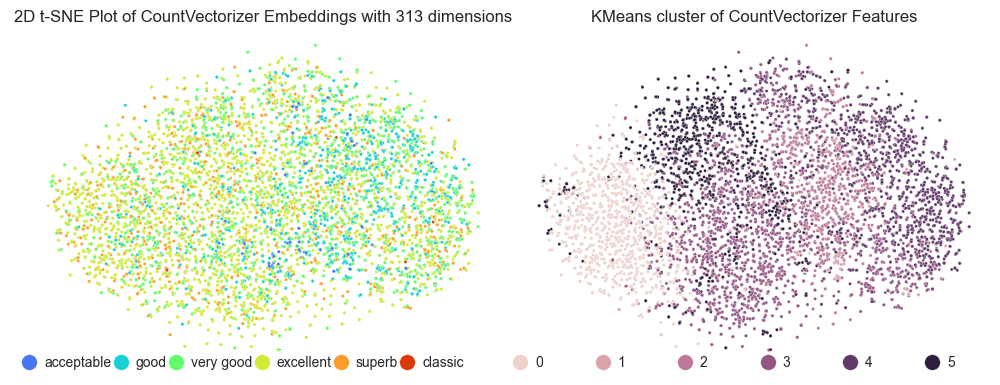

In [20]:
bow_tsne = tsne(bow)
visualize_embeddings(bow_tsne, bow.shape[1], model_name='CountVectorizer', hue=wine_ratings, clusters=cluster(bow).cluster)

**TF-IDF**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

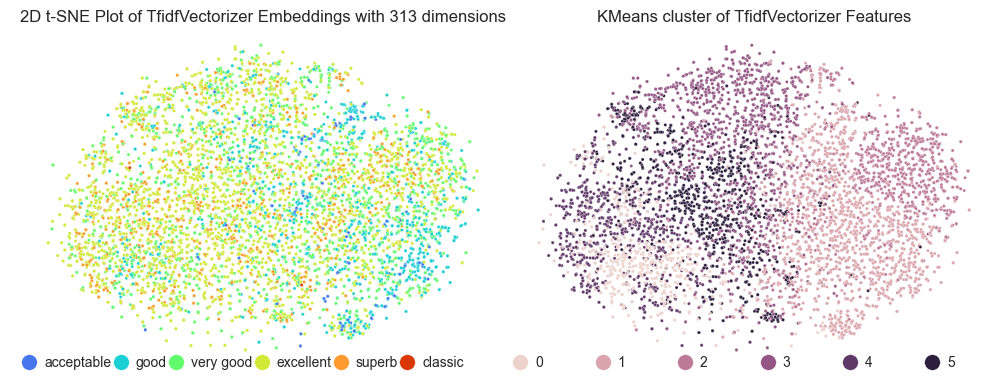

In [21]:
tfidf_tsne = tsne(tfidf)
visualize_embeddings(tfidf_tsne, tfidf.shape[1], model_name='TfidfVectorizer', hue=wine_ratings, clusters=cluster(tfidf).cluster)

**Custom Tokenizer BOW**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

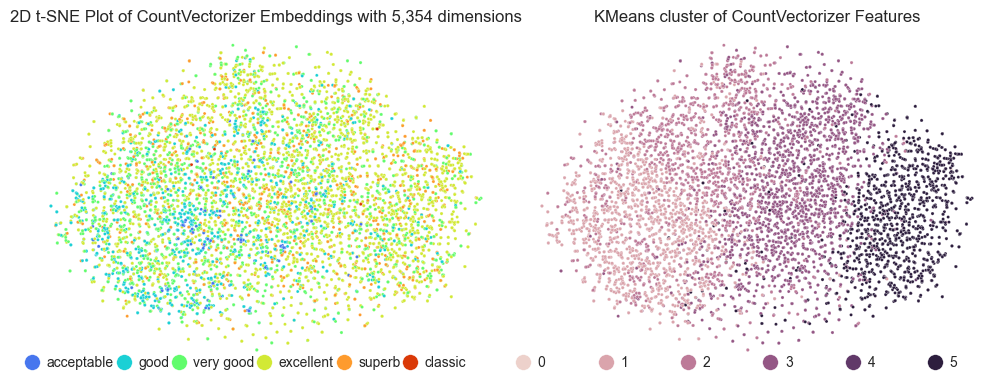

In [22]:
bow_spacy_tsne = tsne(bow_spacy)
visualize_embeddings(bow_spacy_tsne, bow_spacy.shape[1], model_name='CountVectorizer', hue=wine_ratings, clusters=cluster(bow_spacy).cluster)

**Custom Tokenizer TF-IDF**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

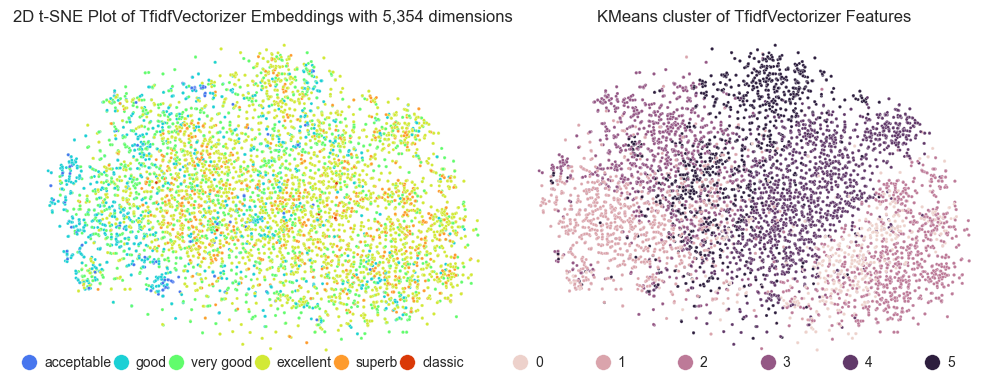

In [23]:
tfidf_spacy_tsne = tsne(tfidf_spacy)
visualize_embeddings(tfidf_spacy_tsne, tfidf_spacy.shape[1], model_name='TfidfVectorizer', hue=wine_ratings, clusters=cluster(tfidf_spacy).cluster)

**MiniLM Embeddings**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

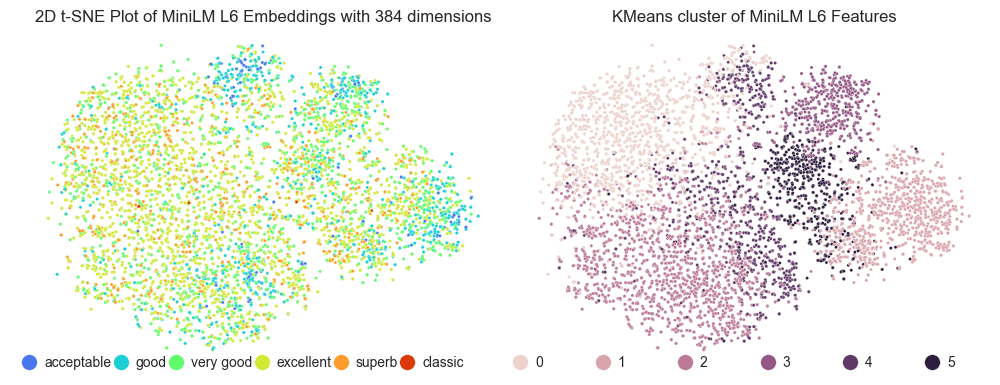

In [24]:
minilm_l6_tsne = tsne(minilm_l6_embeddings)
visualize_embeddings(minilm_l6_tsne, minilm_l6_embeddings.shape[1], model_name='MiniLM L6', hue=wine_ratings, clusters=cluster(minilm_l6_embeddings).cluster)

**Jina v2 Embeddings**

It took $0.2$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

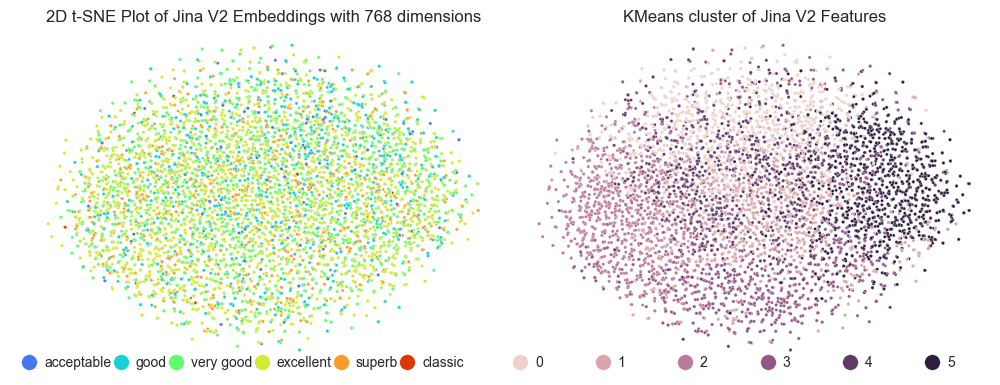

In [25]:
jinav2_tsne = tsne(jinav2_embeddings)
visualize_embeddings(jinav2_tsne, jinav2_embeddings.shape[1], model_name='Jina V2', hue=wine_ratings, clusters=cluster(jinav2_embeddings).cluster)

**MPNET Embeddings**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

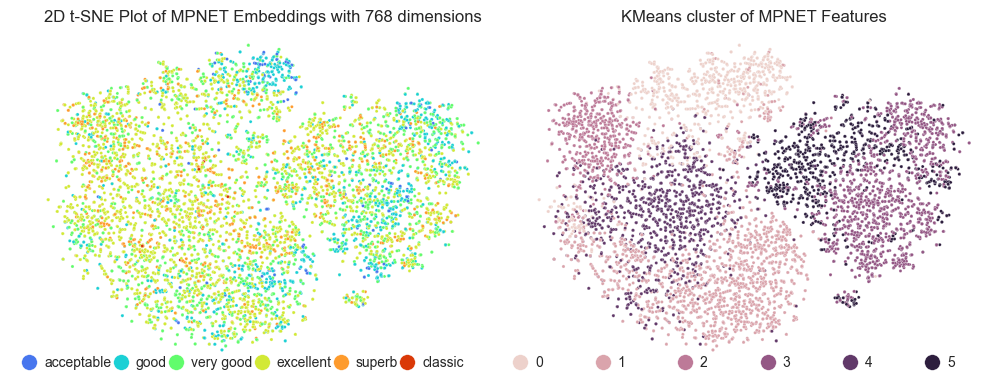

In [26]:
mpnet_tsne = tsne(mpnet_embeddings)
visualize_embeddings(mpnet_tsne, mpnet_embeddings.shape[1], model_name='MPNET', hue=wine_ratings, clusters=cluster(mpnet_embeddings).cluster)

**Jina v3 Embeddings**

It took $0.3$ minutes to perform t-SNE dimension reduction on embeddings for $6,888$ reviews.

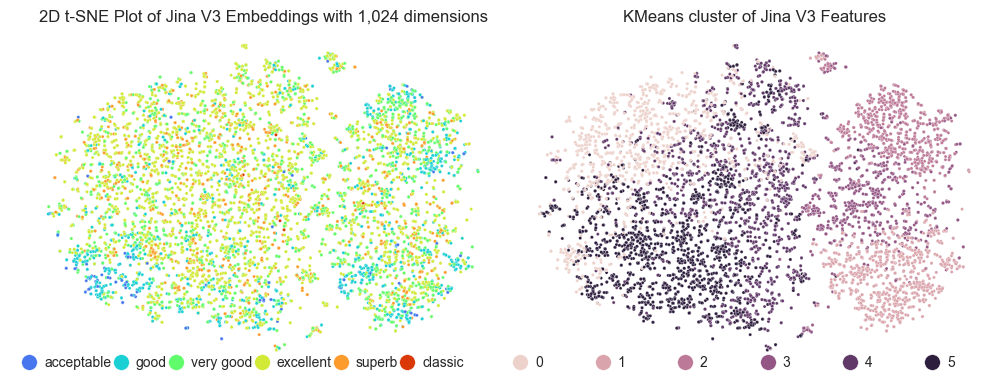

In [27]:
jinav3_tsne = tsne(jinav3_embeddings)
visualize_embeddings(jinav3_tsne, jinav3_embeddings.shape[1], model_name='Jina V3', hue=wine_ratings, clusters=cluster(jinav3_embeddings).cluster)

### Training

**Training Data**

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

X = pd.concat([reviews.year, mpnet_embeddings], axis=1)
X.columns = X.columns.astype(str)
le = LabelEncoder()
y = le.fit_transform(reviews.points)
le_alt = LabelEncoder()
y_alt = le_alt.fit_transform(reviews.rating)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

year         0         1         2         3         4         5  \
69566  2012  0.013812 -0.003759 -0.021267  0.028441 -0.042273  0.039380   
21303  2012  0.007792  0.057693 -0.038562  0.024240 -0.057634  0.025531   
93619  2007 -0.018266  0.064334 -0.042776  0.023260 -0.094765  0.012351   
6282   2011 -0.003424  0.054426 -0.017970 -0.007075 -0.079687  0.020736   
64596  2007  0.025485  0.045220 -0.006220 -0.045443 -0.047736  0.057420   

              6         7         8  ...       758       759       760  \
69566 -0.098909  0.010285 -0.039116  ... -0.084500  0.041987 -0.030429   
21303 -0.026403  0.021395  0.082758  ... -0.072577 -0.015516  0.004454   
93619 -0.061552  0.011585  0.038532  ... -0.098185  0.006425  0.002375   
6282  -0.035845  0.047854  0.073142  ... -0.116727  0.015595 -0.023231   
64596 -0.138011 -0.021873 -0.029343  ... -0.036494  0.031714  0.005543   

            761       762       763       764       765       766       767  
69566 -0.006755  0.007618  0.066973 -0.044869  0.005849  0.042915  0.004238  
21303  0.036650  0.003776  0.029322 -0.042068 -0.007343  0.012399 -0.058092  
93619  0.010981  0.018491  0.027379 -0.047546 -0.003214  0.049820 -0.050390  
6282  -0.004425  0.005548  0.024153 -0.038988 -0.020885  0.021978 -0.030159  
64596  0.009204  0.000056  0.054210 -0.000665  0.030583  0.041355 -0.010818  

[5 rows x 769 columns]

In [29]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
  ('preprocessor', ColumnTransformer([('scaler', StandardScaler(), ['year'])], remainder='passthrough')),
  ('classifier', RandomForestClassifier(max_depth=5, random_state=42))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.373502722323049, 0.20391872278664733)

In [30]:
def assess_feature_matrix(name, features, target):
  # define feature matrix and target vector
  X = pd.concat([reviews.year, features], axis=1)
  X.columns = X.columns.astype(str)
  le = LabelEncoder()
  y = le.fit_transform(reviews[target])

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

  # define a simple classifier
  pipe = Pipeline([
    ('preprocessor', ColumnTransformer([('scaler', StandardScaler(), ['year'])], remainder='passthrough')),
    ('classifier', RandomForestClassifier(max_depth=5, random_state=42))
  ])
  start = time.perf_counter()
  pipe.fit(X_train, y_train)
  duration = time.perf_counter() - start
  return name, target, duration, pipe.score(X_train, y_train), pipe.score(X_test, y_test)

In [31]:
from tqdm import tqdm

features_and_targets = [
  ('length', review_length, 'points'),
  ('length', review_length, 'rating'),
  ('bag-of-words', bow, 'points'),
  ('bag-of-words', bow, 'rating'),
  ('tf-idf', tfidf, 'points'),
  ('tf-idf', tfidf, 'rating'),
  ('spaCy bag-of-words', bow_spacy, 'points'),
  ('spaCy bag-of-words', bow_spacy, 'rating'),
  ('spaCy tf-idf', tfidf_spacy, 'points'),
  ('spaCy tf-idf', tfidf_spacy, 'rating'),
  ('minilm', minilm_l6_embeddings, 'points'),
  ('minilm', minilm_l6_embeddings, 'rating'),
  ('jinav2', jinav2_embeddings, 'points'),
  ('jinav2', jinav2_embeddings, 'rating'),
  ('mpnet', mpnet_embeddings, 'points'),
  ('mpnet', mpnet_embeddings, 'rating'),
  ('jinav3', jinav3_embeddings, 'points'),
  ('jinav3', jinav3_embeddings, 'rating'),
  ('mpnet+len', pd.concat([review_length,mpnet_embeddings], axis=1), 'points'),
  ('mpnet+len', pd.concat([review_length,mpnet_embeddings], axis=1), 'rating'),
]

resutls = [assess_feature_matrix(name, features, target) for name, features, target in tqdm(features_and_targets)]
pd.DataFrame(resutls, columns=['feature','target','duration','accuracy_train','accuracy_test'])

100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


feature  target  duration  accuracy_train  accuracy_test
0               length  points  0.249688        0.260073       0.226415
1               length  rating  0.223437        0.607441       0.590711
2         bag-of-words  points  0.319322        0.263339       0.192308
3         bag-of-words  rating  0.300395        0.487840       0.484761
4               tf-idf  points  0.618287        0.256987       0.186502
5               tf-idf  rating  0.597089        0.546098       0.530479
6   spaCy bag-of-words  points  1.246510        0.186207       0.143687
7   spaCy bag-of-words  rating  1.049311        0.472777       0.472424
8         spaCy tf-idf  points  1.064390        0.232668       0.170537
9         spaCy tf-idf  rating  0.999041        0.485844       0.477504
10              minilm  points  4.998381        0.366243       0.206096
11              minilm  rating  4.424414        0.567332       0.526851
12              jinav2  points  6.749996        0.325045       0.163280
13              jinav2  rating  5.911591        0.474955       0.472424
14               mpnet  points  6.504125        0.373503       0.203919
15               mpnet  rating  5.701974        0.576044       0.543541
16              jinav3  points  7.773083        0.393103       0.195210
17              jinav3  rating  6.844731        0.565154       0.539913
18           mpnet+len  points  6.762458        0.385844       0.216255
19           mpnet+len  rating  5.987699        0.589111       0.555878

## Model Selection

**Given**

In [32]:
X = pd.concat([reviews.year, review_length, mpnet_embeddings], axis=1)
X.columns = X.columns.astype(str)
le = LabelEncoder()
y = le.fit_transform(reviews.points)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

year  description_len         0         1         2         3  \
69566  2012              148  0.013812 -0.003759 -0.021267  0.028441   
21303  2012              304  0.007792  0.057693 -0.038562  0.024240   
93619  2007              386 -0.018266  0.064334 -0.042776  0.023260   
6282   2011              401 -0.003424  0.054426 -0.017970 -0.007075   
64596  2007              176  0.025485  0.045220 -0.006220 -0.045443   

              4         5         6         7  ...       758       759  \
69566 -0.042273  0.039380 -0.098909  0.010285  ... -0.084500  0.041987   
21303 -0.057634  0.025531 -0.026403  0.021395  ... -0.072577 -0.015516   
93619 -0.094765  0.012351 -0.061552  0.011585  ... -0.098185  0.006425   
6282  -0.079687  0.020736 -0.035845  0.047854  ... -0.116727  0.015595   
64596 -0.047736  0.057420 -0.138011 -0.021873  ... -0.036494  0.031714   

            760       761       762       763       764       765       766  \
69566 -0.030429 -0.006755  0.007618  0.066973 -0.044869  0.005849  0.042915   
21303  0.004454  0.036650  0.003776  0.029322 -0.042068 -0.007343  0.012399   
93619  0.002375  0.010981  0.018491  0.027379 -0.047546 -0.003214  0.049820   
6282  -0.023231 -0.004425  0.005548  0.024153 -0.038988 -0.020885  0.021978   
64596  0.005543  0.009204  0.000056  0.054210 -0.000665  0.030583  0.041355   

            767  
69566  0.004238  
21303 -0.058092  
93619 -0.050390  
6282  -0.030159  
64596 -0.010818  

[5 rows x 770 columns]

**Determine Which Classifiers to use**

In [33]:
from sklearn.preprocessing import MinMaxScaler

def evaluate_classifier(name, classifier, target):
  # define a simple classifier
  pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', classifier)
  ])
  start = time.perf_counter()
  pipe.fit(X_train, y_train)
  duration = time.perf_counter() - start
  return name, target, duration, pipe.score(X_train, y_train), pipe.score(X_test, y_test)

evaluate = lambda classifier, target='points': evaluate_classifier(classifier.__class__.__name__, classifier, target)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

classifiers = [
  # Logistic Regression
  (LogisticRegression(max_iter=500, C=0.5, random_state=42, solver='newton-cholesky'), None),
  # Decision Tree Classifier
  (DecisionTreeClassifier(max_depth=50, min_samples_split=5, random_state=42) ,None),
  # Multinomial Naive Bayes Classifier
  (MultinomialNB(), None),
  # Support Vector Classifier
  (SVC(random_state = 42, probability=True), None),
  # Gradient Boost Classifier
  # (GradientBoostingClassifier(random_state=42), None),
  # Ada Boost Classifier
  (AdaBoostClassifier(random_state=42), None),
  # Random Forest Classifier
  (RandomForestClassifier(max_depth=5, random_state=42), None),
  # Calibrated Classifier
  (CalibratedClassifierCV(), None),
  # XGBClassifier
  # (XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, multi_strategy='one_output_per_tree'), None),
]

In [35]:
results_points = pd.DataFrame([evaluate(classifier) for classifier, _ in tqdm(classifiers)], columns=['classifier','target','duration','accuracy_train','accuracy_test'])
results_points

 86%|████████▌ | 6/7 [05:03<00:33, 33.83s/it] /Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
100%|██████████| 7/7 [06:48<00:00, 58.29s/it]


classifier  target    duration  accuracy_train  accuracy_test
0      LogisticRegression  points  188.418726        0.458984       0.242380
1  DecisionTreeClassifier  points    6.129247        0.897096       0.237300
2           MultinomialNB  points    0.052918        0.194737       0.174165
3                     SVC  points   51.314629        0.627042       0.264151
4      AdaBoostClassifier  points   29.070165        0.163339       0.161829
5  RandomForestClassifier  points    6.787409        0.385844       0.216255
6  CalibratedClassifierCV  points  104.554160        0.555354       0.244557

**Repeat for Rating**

In [36]:
le = LabelEncoder()
y = le.fit_transform(reviews.rating)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
X_train.head()

results_rating = pd.DataFrame([evaluate(classifier, target='rating') for classifier, _ in tqdm(classifiers)], columns=['classifier','target','duration','accuracy_train','accuracy_test'])
results_rating

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [03:21<00:00, 28.77s/it]


classifier  target   duration  accuracy_train  accuracy_test
0      LogisticRegression  rating  12.577251        0.724319       0.632801
1  DecisionTreeClassifier  rating   7.585221        0.968966       0.506531
2           MultinomialNB  rating   0.052179        0.508893       0.508708
3                     SVC  rating  81.969672        0.786570       0.637881
4      AdaBoostClassifier  rating  29.698566        0.506352       0.475327
5  RandomForestClassifier  rating   6.389801        0.589111       0.555878
6  CalibratedClassifierCV  rating  38.357186        0.723412       0.608128

In [37]:
# combine results
results = pd.concat([results_points,results_rating], axis=0)
results

classifier  target    duration  accuracy_train  accuracy_test
0      LogisticRegression  points  188.418726        0.458984       0.242380
1  DecisionTreeClassifier  points    6.129247        0.897096       0.237300
2           MultinomialNB  points    0.052918        0.194737       0.174165
3                     SVC  points   51.314629        0.627042       0.264151
4      AdaBoostClassifier  points   29.070165        0.163339       0.161829
5  RandomForestClassifier  points    6.787409        0.385844       0.216255
6  CalibratedClassifierCV  points  104.554160        0.555354       0.244557
0      LogisticRegression  rating   12.577251        0.724319       0.632801
1  DecisionTreeClassifier  rating    7.585221        0.968966       0.506531
2           MultinomialNB  rating    0.052179        0.508893       0.508708
3                     SVC  rating   81.969672        0.786570       0.637881
4      AdaBoostClassifier  rating   29.698566        0.506352       0.475327
5  RandomForestClassifier  rating    6.389801        0.589111       0.555878
6  CalibratedClassifierCV  rating   38.357186        0.723412       0.608128

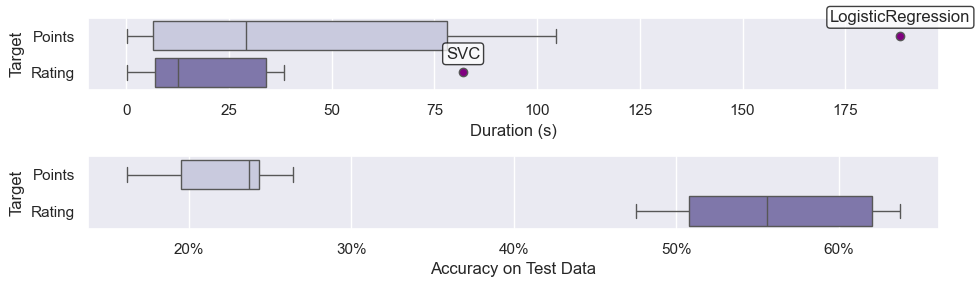

In [57]:
import warnings

fig, axes = plt.subplots(2, 1, figsize=(10,3))

ax = sns.boxplot(data = results, x='duration', y='target', hue='target', palette='Purples', ax=axes[0], flierprops={'markerfacecolor': 'purple'})
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Target')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['Points', 'Rating'])

# Iterate through fliers and add annotations
for i, flier in enumerate(ax.findobj(match=lambda x: type(x) == plt.Line2D and x.get_marker() == 'o')):
    x_data, y_data = flier.get_data()
    for x, y in zip(x_data, y_data):
        classifier=results.query(f'duration == {x}').classifier.values[0]
        ax.text(x, y-0.3, f'{classifier}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=0.2'))

ax = sns.boxplot(results, x='accuracy_test', y='target', ax=axes[1], hue='target', palette='Purples')
ax.set_xlabel('Accuracy on Test Data')
ax.set_ylabel('Target')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['Points', 'Rating'])
with warnings.catch_warnings():
  warnings.filterwarnings(action='ignore', category=UserWarning)
  ax.set_xticklabels([f'{float(v):.0%}' for v in ax.get_xticks()])

plt.tight_layout()
plt.show()

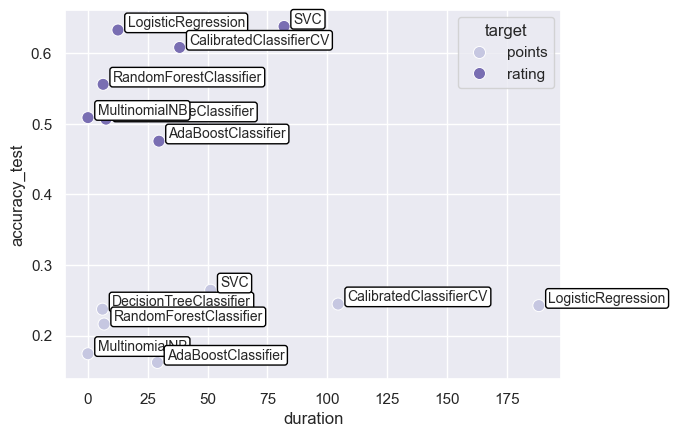

In [47]:
ax = sns.scatterplot(data=results, x='duration', y='accuracy_test', hue='target', palette='Purples', s=75)
# Annotate each point with its label
for i, row in results.iterrows():
    # ax.set_ylim(.0, .20)
    ax.text(row['duration']+4, row['accuracy_test']+.00025, row['classifier'], fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
            horizontalalignment='left', verticalalignment='bottom')

**Parameter Hypertuning**

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train, plot=True)

model.score(X_train, y_train), model.score(X_test, y_test)

Learning rate set to 0.086322
0:	learn: 1.6855315	total: 448ms	remaining: 7m 27s
1:	learn: 1.6029866	total: 709ms	remaining: 5m 53s
2:	learn: 1.5329188	total: 1s	remaining: 5m 34s
3:	learn: 1.4726900	total: 1.29s	remaining: 5m 20s
4:	learn: 1.4224817	total: 1.59s	remaining: 5m 16s
5:	learn: 1.3741908	total: 1.85s	remaining: 5m 6s
6:	learn: 1.3378830	total: 2.16s	remaining: 5m 6s
7:	learn: 1.2995682	total: 2.43s	remaining: 5m 1s
8:	learn: 1.2718043	total: 2.71s	remaining: 4m 58s
9:	learn: 1.2445037	total: 2.96s	remaining: 4m 52s
10:	learn: 1.2224912	total: 3.22s	remaining: 4m 49s
11:	learn: 1.1984327	total: 3.5s	remaining: 4m 48s
12:	learn: 1.1770792	total: 3.78s	remaining: 4m 46s
13:	learn: 1.1547746	total: 4.07s	remaining: 4m 46s
14:	learn: 1.1395144	total: 4.39s	remaining: 4m 48s
15:	learn: 1.1198573	total: 4.63s	remaining: 4m 45s
16:	learn: 1.1023968	total: 4.92s	remaining: 4m 44s
17:	learn: 1.0914741	total: 5.19s	remaining: 4m 43s
18:	learn: 1.0816157	total: 5.51s	remaining: 4m 44s

(0.9996370235934664, 0.6545718432510885)

In [60]:
from scipy.stats import randint, uniform

catboost_params_dist = {
  'depth': randint(4, 10),
  'learning_rate': uniform(0.01, 0.3),
  'iterations': randint(10, 1_000),
  'l2_leaf_reg': randint(1, 10),
  'border_count': randint(1, 255),
  'bagging_temperature': uniform(0.0, 1.0),
  'random_strength': uniform(0.0, 1.0),
}

In [61]:
from sklearn.model_selection import RandomizedSearchCV

randsearch = RandomizedSearchCV(estimator=model, param_distributions=catboost_params_dist, cv=5, verbose=0, return_train_score=True, random_state=42)
randsearch.fit(X_train, y_train)

randsearch.score(X_train, y_train), randsearch.score(X_test, y_test)

0:	learn: 1.7143457	total: 94.8ms	remaining: 7.58s
1:	learn: 1.6481289	total: 180ms	remaining: 7.11s
2:	learn: 1.5939376	total: 275ms	remaining: 7.14s
3:	learn: 1.5427098	total: 368ms	remaining: 7.08s
4:	learn: 1.4950906	total: 466ms	remaining: 7.09s
5:	learn: 1.4537507	total: 550ms	remaining: 6.88s
6:	learn: 1.4181347	total: 852ms	remaining: 9.01s
7:	learn: 1.3840694	total: 1s	remaining: 9.15s
8:	learn: 1.3519552	total: 1.1s	remaining: 8.79s
9:	learn: 1.3229926	total: 1.28s	remaining: 9.1s
10:	learn: 1.2984371	total: 1.41s	remaining: 8.96s
11:	learn: 1.2748071	total: 1.52s	remaining: 8.77s
12:	learn: 1.2534180	total: 1.68s	remaining: 8.8s
13:	learn: 1.2322416	total: 1.79s	remaining: 8.55s
14:	learn: 1.2140214	total: 1.87s	remaining: 8.24s
15:	learn: 1.1959072	total: 1.98s	remaining: 8.04s
16:	learn: 1.1787513	total: 2.08s	remaining: 7.84s
17:	learn: 1.1634677	total: 2.18s	remaining: 7.64s
18:	learn: 1.1502515	total: 2.29s	remaining: 7.48s
19:	learn: 1.1362572	total: 2.38s	remaining: 7

(0.9740471869328494, 0.6531204644412192)

In [227]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding
from tensorflow.keras.layers import Dropout,Activation,Bidirectional,GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.utils import to_categorical


In [69]:
reviews

description  points  \
25      Oak and earth intermingle around robust aromas...      87   
145     Cooked cranberry is spiced with anise, pepperc...      91   
152     From a promising new project, the nose of this...      91   
169     This wine is put together from multiple vineya...      91   
181     Crisp, coastal acidity dominates this wine, ma...      88   
...                                                   ...     ...   
129862  Earthy forest floor and Asian spice ride atop ...      90   
129872  Almost like liquid cherry pie—but not sweet—th...      90   
129888  Round red cherry, deep plum and ripe cranberry...      91   
129912  From the Ranch House block of the famous viney...      91   
129920  Shows the clean, citrus acid juiciness and sil...      91   

                     region_1               winery  year     rating  
25               Sonoma Coast  Castello di Amorosa  2011  very good  
145     Santa Lucia Highlands           Testarossa  2013  excellent  
152             Carmel Valley      Albatross Ridge  2012  excellent  
169      Russian River Valley     Dutton-Goldfield  2014  excellent  
181               Arroyo Seco   McIntyre Vineyards  2006  very good  
...                       ...                  ...   ...        ...  
129862           Green Valley           River Road  2014  excellent  
129872        Anderson Valley             Brutocao  2013  excellent  
129888  Santa Lucia Highlands          August West  2015  excellent  
129912           Sonoma Coast              Dunstan  2014  excellent  
129920        Sta. Rita Hills                 Pali  2006  excellent  

[6888 rows x 6 columns]

In [97]:
from sklearn.preprocessing import FunctionTransformer

model = SentenceTransformer('all-mpnet-base-v2')
to_embeddings = lambda series: model.encode(series.to_list(), normalize_embeddings=False, show_progress_bar=True, device='mps')

to_features_out = lambda self, cols: [f'{i}' for i in range(768)]

transformer = ColumnTransformer([#('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety']),
                                 ('scaler', MinMaxScaler(), ['year', 'description_len']),
                                 ('embeds', Pipeline([('encode', FunctionTransformer(to_embeddings, feature_names_out=to_features_out)),
                                                      ('scaler', MinMaxScaler()),
                                                    ]), 'description'),
                                ])
x = transformer.fit_transform(pd.concat([reviews[['year', 'description']],review_length], axis=1))
transformer

Batches:   0%|          | 0/216 [00:00<?, ?it/s]

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['year', 'description_len']),
                                ('embeds',
                                 Pipeline(steps=[('encode',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x193921580>,
                                                                      func=<function <lambda> at 0x193921800>)),
                                                 ('scaler', MinMaxScaler())]),
                                 'description')])

In [98]:
X = pd.DataFrame(x, index=reviews.index, columns=transformer.get_feature_names_out())
X.info()
X

<class 'pandas.core.frame.DataFrame'>
Index: 6888 entries, 25 to 129920
Columns: 770 entries, scaler__year to embeds__767
dtypes: float64(770)
memory usage: 40.5 MB


scaler__year  scaler__description_len  embeds__0  embeds__1  \
25              0.75                 0.330275   0.468178   0.427830   
145             0.85                 0.342508   0.530540   0.497910   
152             0.80                 0.470948   0.520759   0.567906   
169             0.90                 0.434251   0.432624   0.541319   
181             0.50                 0.269113   0.375897   0.487706   
...              ...                      ...        ...        ...   
129862          0.90                 0.304281   0.486731   0.415416   
129872          0.85                 0.345566   0.279469   0.601056   
129888          0.95                 0.374618   0.480968   0.437694   
129912          0.90                 0.266055   0.491440   0.531212   
129920          0.50                 0.340979   0.497760   0.430455   

        embeds__2  embeds__3  embeds__4  embeds__5  embeds__6  embeds__7  ...  \
25       0.419624   0.624886   0.694053   0.426831   0.360322   0.299849  ...   
145      0.503550   0.246528   0.323337   0.649141   0.663929   0.666777  ...   
152      0.381758   0.502533   0.311023   0.726372   0.458411   0.361007  ...   
169      0.603651   0.720500   0.148112   0.388928   0.650311   0.439227  ...   
181      0.489231   0.414670   0.346397   0.805391   0.170645   0.198433  ...   
...           ...        ...        ...        ...        ...        ...  ...   
129862   0.462529   0.430732   0.362959   0.627755   0.222439   0.174357  ...   
129872   0.298240   0.367166   0.267111   0.530164   0.415173   0.178556  ...   
129888   0.426299   0.405355   0.414049   0.610803   0.600478   0.391402  ...   
129912   0.498683   0.485893   0.399971   0.447626   0.546479   0.518780  ...   
129920   0.240428   0.422771   0.469027   0.563320   0.341071   0.499087  ...   

        embeds__758  embeds__759  embeds__760  embeds__761  embeds__762  \
25         0.459721     0.520117     0.371860     0.457351     0.593724   
145        0.714926     0.529364     0.397299     0.677294     0.674278   
152        0.449059     0.425247     0.428665     0.471475     0.308422   
169        0.629687     0.365212     0.693702     0.796264     0.581370   
181        0.272345     0.612583     0.527360     0.456961     0.493579   
...             ...          ...          ...          ...          ...   
129862     0.321632     0.445904     0.730959     0.662641     0.284767   
129872     0.702009     0.446838     0.548989     0.482059     0.508734   
129888     0.626143     0.551229     0.335805     0.472808     0.574755   
129912     0.381509     0.447270     0.517180     0.653943     0.604782   
129920     0.376621     0.527107     0.688657     0.253714     0.654211   

        embeds__763  embeds__764  embeds__765  embeds__766  embeds__767  
25         0.756900     0.318805     0.415583     0.643899     0.730467  
145        0.498519     0.475120     0.550004     0.278598     0.198345  
152        0.639612     0.426554     0.553164     0.456186     0.306975  
169        0.319601     0.010395     0.463987     0.364058     0.240162  
181        0.537165     0.432238     0.565863     0.464301     0.519964  
...             ...          ...          ...          ...          ...  
129862     0.470745     0.302374     0.714005     0.562867     0.297869  
129872     0.671042     0.393814     0.395815     0.622899     0.582901  
129888     0.634297     0.601313     0.503834     0.203453     0.357092  
129912     0.466646     0.309507     0.454294     0.487880     0.360346  
129920     0.609178     0.499113     0.624902     0.603827     0.573287  

[6888 rows x 770 columns]

In [132]:
ohe = OneHotEncoder()
y = ohe.fit_transform(reviews.rating.to_frame())
print(ohe.categories_)
Y = pd.DataFrame(y.todense(), index=reviews.index, columns=ohe.categories_)
Y.head()

[array(['acceptable', 'classic', 'excellent', 'good', 'superb',
       'very good'], dtype=object)]


acceptable classic excellent good superb very good
25         0.0     0.0       0.0  0.0    0.0       1.0
145        0.0     0.0       1.0  0.0    0.0       0.0
152        0.0     0.0       1.0  0.0    0.0       0.0
169        0.0     0.0       1.0  0.0    0.0       0.0
181        0.0     0.0       0.0  0.0    0.0       1.0

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, stratify=Y, random_state=42)

In [166]:
inputs = layers.Input(shape=(X.shape[1],))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs, x)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 770)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,974 (453.02 KB)

 Trainable params: 115,974 (453.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = EarlyStopping(monitor='accuracy', patience=3)

start = time.perf_counter()
history = model.fit(x=X_train.to_numpy(), y=y_train.to_numpy(), validation_data=(X_test.to_numpy(), y_test.to_numpy()), epochs=100, batch_size=64, callbacks=[callback])
training_time = time.perf_counter() - start
print(f'neural network training time: {training_time/60:.2f} min.')

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7125 - loss: 0.6552 - val_accuracy: 0.6295 - val_loss: 0.9107
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7395 - loss: 0.6099 - val_accuracy: 0.6388 - val_loss: 0.9190
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7337 - loss: 0.6291 - val_accuracy: 0.6324 - val_loss: 0.9141
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7492 - loss: 0.5993 - val_accuracy: 0.6295 - val_loss: 0.9577
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7603 - loss: 0.5826 - val_accuracy: 0.6516 - val_loss: 0.9294
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7613 - loss: 0.5680 - val_accuracy: 0.6318 - val_loss: 0.9164
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.5828 - val_accuracy: 0.6504 - val_loss: 0.9112
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7510 - loss: 0.5773 - val_accuracy: 0.6463 - v

In [172]:
model.evaluate(x=X_test, y=y_test, return_dict=True)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6302 - loss: 1.3372


{'accuracy': 0.6364692449569702, 'loss': 1.2435799837112427}

In [225]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print(np.min(y_pred), np.max(y_pred))

y_preds = np.apply_along_axis(lambda v: ohe.categories_[0][v], axis=0, arr=y_pred)

print(f'{accuracy_score(ohe.inverse_transform(y_test), y_preds):.1%}')

conf_matrix = confusion_matrix(ohe.inverse_transform(y_test), y_preds, labels=ratings)

print(classification_report(ohe.inverse_transform(y_test), y_preds, labels=ratings))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
0 5
63.6%
              precision    recall  f1-score   support

  acceptable       0.62      0.32      0.43        31
        good       0.69      0.57      0.63       274
   very good       0.57      0.42      0.49       420
   excellent       0.67      0.85      0.75       814
      superb       0.46      0.34      0.39       181
     classic       0.00      0.00      0.00         2

    accuracy                           0.64      1722
   macro avg       0.50      0.42      0.45      1722
weighted avg       0.62      0.64      0.62      1722



/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/patrick/Documents/personal/ucb/oenologist/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

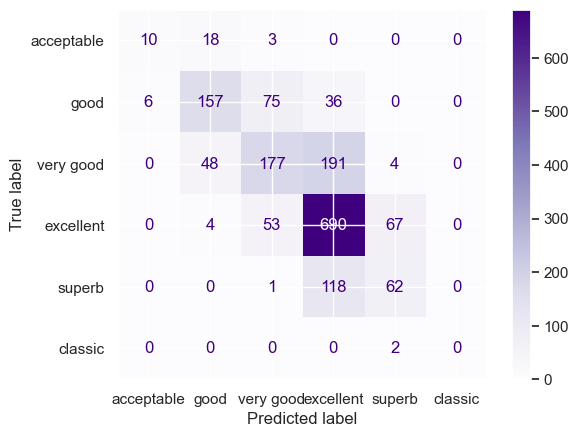

In [232]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=ratings)
disp.plot(cmap='Purples')
plt.show()

In [ ]:
classifiers = [
  # Logistic Regression
  (LogisticRegression(max_iter=500, C=0.5, random_state=42, solver='newton-cholesky'), None),
  # Decision Tree Classifier
  (DecisionTreeClassifier(max_depth=50, min_samples_split=5, random_state=42) ,None),
  # Multinomial Naive Bayes Classifier
  (MultinomialNB(), None),
  # Support Vector Classifier
  (SVC(random_state = 42, probability=True), None),
  # Gradient Boost Classifier
  # (GradientBoostingClassifier(random_state=42), None),
  # Ada Boost Classifier
  (AdaBoostClassifier(random_state=42), None),
  # Random Forest Classifier
  (RandomForestClassifier(max_depth=5, random_state=42), None),
  # Calibrated Classifier
  (CalibratedClassifierCV(), None),
  # XGBClassifier
  # (XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, multi_strategy='one_output_per_tree'), None),
]




grid = GridSearchCV()



**Neural Network**

In [245]:
y = pd.Series(np.where(reviews.points > 89, 1, 0), index=reviews.index, name='rating')
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

In [249]:
inputs = layers.Input(shape=(X.shape[1],))
x = layers.Dense(128, activation='relu')(inputs)
# x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 770)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        98,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,817 (386.00 KB)

 Trainable params: 98,817 (386.00 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
history = model.fit(x=X_train.to_numpy(), y=y_train.to_numpy(), validation_data=(X_test.to_numpy(), y_test.to_numpy()), epochs=100, batch_size=1024)#, callbacks=[callback])
training_time = time.perf_counter() - start
print(f'neural network training time: {training_time/60:.2f} min.')

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4194 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4291 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4254 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4254 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4178 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4243 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4286 - loss: 0.0000e+00 - val_accuracy: 0.4210 - val_loss: 0.0000e+00
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 

In [255]:
# TODO Class weights